# 2. Evaluating Mayinga assemblies

> evaluating polishing strategies for de novo vs. reference guided assemblies, as well evaluating fast vs. high accuracy basecalling

***

## Overview

* calculate consensus identity

* check structural and nucleotide differences

***

**TODO**

1. colour snps in MSA viewer
2. filter coverage for nucfdiff - e.g. only check differences in areas where coverage > 50x

***

## Consensus identity

Grab the mayinga reference genome:

In [1]:
!find ./ -name GCF_000848505.1_ViralProj14703_genomic.fna.gz -exec gunzip -c {} + > tmp/mayinga-ref-genome.fasta

Collect all the mayinga assemblies from the pipeline outputs (for both fast and hac):

In [3]:
# get a file list of all the polished assemblies we just made
!find $PWD/pipelines/data/ebov-dn-assemblies/r941_min*/*barcode-09.assembly.racon.*.fasta > tmp/mayinga-assemblies.list

Calculate the consensus identity for each Mayinga sample compared to the reference:

* this can be calculated from columns 10 and 11 of a PAF alignment file
* [hengi li's take on sequence identity](https://lh3.github.io/2018/11/25/on-the-definition-of-sequence-identity)

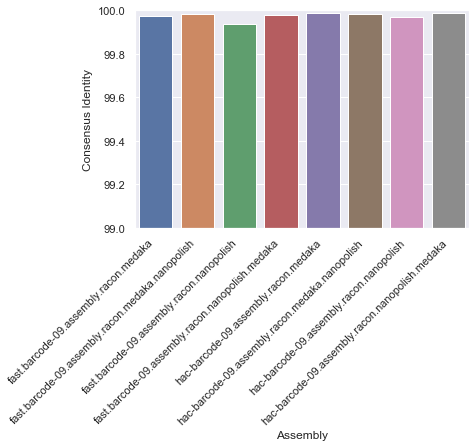

In [9]:
# import the minimap2 binding (mappy)
import os
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set(color_codes=True)
import mappy as mp

# set up the results list
idents = []

# set up the index
a = mp.Aligner("tmp/mayinga-ref-genome.fasta", preset="asm10")  # load or build index
if not a: raise Exception("ERROR: failed to load/build index")

# open the list of assemblies we made
with open("tmp/mayinga-assemblies.list", "r") as fh:
    
    # align each assembly to the reference
    for line in fh:
        base=os.path.basename(line)
        assemblyName=os.path.splitext(base)[0]
        for name, seq, qual in mp.fastx_read(line.rstrip()):
            
            # get the best hit for each assembly
            topHit = 0.0
            for hit in a.map(seq):
                if (hit.mlen/hit.blen) > topHit:
                    topHit = (hit.mlen/hit.blen) * 100.0
            
            # store for plotting later
            idents.append([assemblyName, topHit])
            
# plot the consensus identities
df = pd.DataFrame(idents, columns = ['Assembly', 'Consensus Identity']) 
chart = sns.barplot(x="Assembly", y="Consensus Identity", data=df)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light')
chart.set(ylim=(99, 100))
chart

## Structural and nucleotide differences

Use NucDiff to get some stats on SNPs, InDels and rearrangements:

In [10]:
# fast
!nucdiff tmp/mayinga-ref-genome.fasta pipelines/data/ebov-dn-assemblies/r941_min_fast/*barcode-09.assembly.raw.fasta tmp/nucdiff-out unpolished-f
!nucdiff tmp/mayinga-ref-genome.fasta pipelines/data/ebov-dn-assemblies/r941_min_fast/*barcode-09.assembly.racon.medaka.fasta tmp/nucdiff-out medaka-f
!nucdiff tmp/mayinga-ref-genome.fasta pipelines/data/ebov-dn-assemblies/r941_min_fast/*barcode-09.assembly.racon.medaka.nanopolish.fasta tmp/nucdiff-out medaka-nanopolish-f
!nucdiff tmp/mayinga-ref-genome.fasta pipelines/data/ebov-dn-assemblies/r941_min_fast/*barcode-09.assembly.racon.nanopolish.fasta tmp/nucdiff-out nanopolish-f
!nucdiff tmp/mayinga-ref-genome.fasta pipelines/data/ebov-dn-assemblies/r941_min_fast/*barcode-09.assembly.racon.nanopolish.medaka.fasta tmp/nucdiff-out nanopolish-medaka-f

# hac
!nucdiff tmp/mayinga-ref-genome.fasta pipelines/data/ebov-dn-assemblies/r941_min_hac/*barcode-09.assembly.raw.fasta tmp/nucdiff-out unpolished-h
!nucdiff tmp/mayinga-ref-genome.fasta pipelines/data/ebov-dn-assemblies/r941_min_hac/*barcode-09.assembly.racon.medaka.fasta tmp/nucdiff-out medaka-h
!nucdiff tmp/mayinga-ref-genome.fasta pipelines/data/ebov-dn-assemblies/r941_min_hac/*barcode-09.assembly.racon.medaka.nanopolish.fasta tmp/nucdiff-out medaka-nanopolish-h
!nucdiff tmp/mayinga-ref-genome.fasta pipelines/data/ebov-dn-assemblies/r941_min_hac/*barcode-09.assembly.racon.nanopolish.fasta tmp/nucdiff-out nanopolish-h
!nucdiff tmp/mayinga-ref-genome.fasta pipelines/data/ebov-dn-assemblies/r941_min_hac/*barcode-09.assembly.racon.nanopolish.medaka.fasta tmp/nucdiff-out nanopolish-medaka-h


Run NUCmer...

1: PREPARING DATA
2,3: RUNNING mummer AND CREATING CLUSTERS
# reading input file "/Users/willrowe/Desktop/signal-check/tmp/nucdiff-out/unpolished-f.ntref" of length 18960
# construct suffix tree for sequence of length 18960
# (maximum reference length is 536870908)
# (maximum query length is 4294967295)
# CONSTRUCTIONTIME //anaconda3/envs/notebook-analysis/opt/mummer-3.23/mummer /Users/willrowe/Desktop/signal-check/tmp/nucdiff-out/unpolished-f.ntref 0.00
# reading input file "/Users/willrowe/Desktop/signal-check/pipelines/data/ebov-dn-assemblies/r941_min_fast/fast.barcode-09.assembly.raw.fasta" of length 18634
# matching query-file "/Users/willrowe/Desktop/signal-check/pipelines/data/ebov-dn-assemblies/r941_min_fast/fast.barcode-09.assembly.raw.fasta"
# against subject-file "/Users/willrowe/Desktop/signal-check/tmp/nucdiff-out/unpolished-f.ntref"
# COMPLETETIME //anaconda3/envs/notebook-analysis/opt/mummer-3.23/mummer /Users/willrowe/Desktop/signal-check/tmp/nucdiff-out


Find differences...

The difference detection inside fragments step is complete

The difference detection between fragments step is complete

Run NUCmer...

1: PREPARING DATA
2,3: RUNNING mummer AND CREATING CLUSTERS
# reading input file "/Users/willrowe/Desktop/signal-check/tmp/nucdiff-out/nanopolish-f.ntref" of length 18960
# construct suffix tree for sequence of length 18960
# (maximum reference length is 536870908)
# (maximum query length is 4294967295)
# CONSTRUCTIONTIME //anaconda3/envs/notebook-analysis/opt/mummer-3.23/mummer /Users/willrowe/Desktop/signal-check/tmp/nucdiff-out/nanopolish-f.ntref 0.00
# reading input file "/Users/willrowe/Desktop/signal-check/pipelines/data/ebov-dn-assemblies/r941_min_fast/fast.barcode-09.assembly.racon.nanopolish.fasta" of length 18904
# matching query-file "/Users/willrowe/Desktop/signal-check/pipelines/data/ebov-dn-assemblies/r941_min_fast/fast.barcode-09.assembly.racon.nanopolish.fasta"
# against subject-file "/Users/willrowe/Desktop/signal

1: PREPARING DATA
2,3: RUNNING mummer AND CREATING CLUSTERS
# reading input file "/Users/willrowe/Desktop/signal-check/tmp/nucdiff-out/medaka-h.ntref" of length 18960
# construct suffix tree for sequence of length 18960
# (maximum reference length is 536870908)
# (maximum query length is 4294967295)
# CONSTRUCTIONTIME //anaconda3/envs/notebook-analysis/opt/mummer-3.23/mummer /Users/willrowe/Desktop/signal-check/tmp/nucdiff-out/medaka-h.ntref 0.00
# reading input file "/Users/willrowe/Desktop/signal-check/pipelines/data/ebov-dn-assemblies/r941_min_hac/hac-barcode-09.assembly.racon.medaka.fasta" of length 18916
# matching query-file "/Users/willrowe/Desktop/signal-check/pipelines/data/ebov-dn-assemblies/r941_min_hac/hac-barcode-09.assembly.racon.medaka.fasta"
# against subject-file "/Users/willrowe/Desktop/signal-check/tmp/nucdiff-out/medaka-h.ntref"
# COMPLETETIME //anaconda3/envs/notebook-analysis/opt/mummer-3.23/mummer /Users/willrowe/Desktop/signal-check/tmp/nucdiff-out/medaka-h.ntre

1: PREPARING DATA
2,3: RUNNING mummer AND CREATING CLUSTERS
# reading input file "/Users/willrowe/Desktop/signal-check/tmp/nucdiff-out/nanopolish-medaka-h.ntref" of length 18960
# construct suffix tree for sequence of length 18960
# (maximum reference length is 536870908)
# (maximum query length is 4294967295)
# CONSTRUCTIONTIME //anaconda3/envs/notebook-analysis/opt/mummer-3.23/mummer /Users/willrowe/Desktop/signal-check/tmp/nucdiff-out/nanopolish-medaka-h.ntref 0.00
# reading input file "/Users/willrowe/Desktop/signal-check/pipelines/data/ebov-dn-assemblies/r941_min_hac/hac-barcode-09.assembly.racon.nanopolish.medaka.fasta" of length 18916
# matching query-file "/Users/willrowe/Desktop/signal-check/pipelines/data/ebov-dn-assemblies/r941_min_hac/hac-barcode-09.assembly.racon.nanopolish.medaka.fasta"
# against subject-file "/Users/willrowe/Desktop/signal-check/tmp/nucdiff-out/nanopolish-medaka-h.ntref"
# COMPLETETIME //anaconda3/envs/notebook-analysis/opt/mummer-3.23/mummer /Users/will

In [16]:
# nucdiff will report SNPs, InDels and rearrangements, as well as the breadth of coverage, compared to the reference
import glob
from tabulate import tabulate

def parseNucDiff(ndFiles):
    dfs = []
    for f in ndFiles:
        fn = os.path.basename(f).replace('_stat.out', '')
        df = pd.read_csv(f, sep='\t', header=None, index_col=0)
        df.columns = [fn]
        dfs.append(df)
    combined = pd.concat(dfs, axis=1, sort=False)
    #stats = combined.loc[ ['Total number', 'Insertions', 'Deletions', 'Substitutions', 'Uncovered ref regions num', 'Uncovered ref regions len'] , : ]
    return combined.loc[ ['Total number', 'Insertions', 'Deletions', 'Substitutions'] , : ]

fastBasecalls = [i for i in glob.glob('tmp/nucdiff-out/results/*-f_stat.out')]
hacBasecalls = [i for i in glob.glob('tmp/nucdiff-out/results/*-h_stat.out')]

fastBasecalls.sort()
hacBasecalls.sort()

fastTable = parseNucDiff(fastBasecalls)
print("fast basecalling:")
print(tabulate(fastTable, headers='keys', tablefmt='psql'))
print()

hacTable = parseNucDiff(hacBasecalls)
print("high accuracy basecalling:")
print(tabulate(hacTable, headers='keys', tablefmt='psql'))

fast basecalling:
+---------------+------------+-----------------------+----------------+-----------------------+----------------+
| 0             |   medaka-f |   medaka-nanopolish-f |   nanopolish-f |   nanopolish-medaka-f |   unpolished-f |
|---------------+------------+-----------------------+----------------+-----------------------+----------------|
| Total number  |          6 |                     4 |             14 |                     5 |           1311 |
| Insertions    |          1 |                     1 |              2 |                     1 |            339 |
| Deletions     |          4 |                     1 |             10 |                     3 |            466 |
| Substitutions |          1 |                     2 |              2 |                     1 |            506 |
+---------------+------------+-----------------------+----------------+-----------------------+----------------+

high accuracy basecalling:
+---------------+------------+--------------------

Now let's create a multiple sequence alignment to visualise the differences:
* use sed to label each fasta header in the assemblies with the basecalling model

In [17]:
!cp tmp/mayinga-ref-genome.fasta tmp/mayinga-assemblies.fasta
!sed s/contig/fast-/ pipelines/data/ebov-dn-assemblies/r941_min_fast/*barcode-09.assembly.racon* >> tmp/mayinga-assemblies.fasta
!sed s/contig/hac-/ pipelines/data/ebov-dn-assemblies/r941_min_hac/*barcode-09.assembly.racon* >> tmp/mayinga-assemblies.fasta

In [18]:
# generate a multiple sequence alignment using Muscle
from Bio.Align.Applications import MuscleCommandline
muscle_cmd = MuscleCommandline(input = "tmp/mayinga-assemblies.fasta", out = "tmp/mayinga-assembly-alignment.msa", clw=True)
muscle_cmd()

('',
 '\nMUSCLE v3.8.1551 by Robert C. Edgar\n\nhttp://www.drive5.com/muscle\nThis software is donated to the public domain.\nPlease cite: Edgar, R.C. Nucleic Acids Res 32(5), 1792-97.\n\nmayinga-assemblies 9 seqs, lengths min 18904, max 18959, avg 18917\n00:00:00      2 MB(0%)  Iter   1    2.22%  K-mer dist pass 1\n00:00:00      2 MB(0%)  Iter   1  100.00%  K-mer dist pass 1\n00:00:00      2 MB(0%)  Iter   1    2.22%  K-mer dist pass 2\n00:00:00      2 MB(0%)  Iter   1  100.00%  K-mer dist pass 2\n00:00:00     24 MB(0%)  Iter   1   12.50%  Align node       \n00:00:04    433 MB(3%)  Iter   1   25.00%  Align node\n00:00:08    444 MB(3%)  Iter   1   37.50%  Align node\n00:00:12    450 MB(3%)  Iter   1   50.00%  Align node\n00:00:16    456 MB(3%)  Iter   1   62.50%  Align node\n00:00:21    461 MB(3%)  Iter   1   75.00%  Align node\n00:00:26    467 MB(3%)  Iter   1   87.50%  Align node\n00:00:31    473 MB(3%)  Iter   1  100.00%  Align node\n00:00:35    479 MB(3%)  Iter   1  100.00%  Align 

In [21]:
# print using BioPython
from Bio import AlignIO
alignment = AlignIO.read("tmp/mayinga-assembly-alignment.msa", "clustal")
print(alignment.format("clustal"))

CLUSTAL X (3.8) multiple sequence alignment


NC_002549.1                         CGGACACACAAAAAGAAAGAAGAATTTTTAGGATCTTTTGTGTGCGAATA
medaka.nanopolish.hac-1             --------------------------------------------------
nanopolish.hac-1                    --------------------------------------------------
medaka.fast-1                       --------------------------------------------------
medaka.hac-1                        --------------------------------------------------
nanopolish.medaka.hac-1             --------------------------------------------------
nanopolish.medaka.fast-1            --------------------------------------------------
nanopolish.fast-1                   --------------------------------------------------
medaka.nanopolish.fast-1            --------------------------------------------------
                                                                                      

NC_002549.1                         ACTATGAGGAAGATTAATAATTTTCCTCTCATTGAAATTTATATCGG

In [23]:
from Bio.Align import AlignInfo
summary= AlignInfo.SummaryInfo(alignment)
print(summary)